In [1]:
from param import Param
from sde import *
from fparam import *
import numpy as np
import math
from matplotlib import pyplot as plt

In [2]:
# We used calibrated heston model
params = {
    "h_0"  : Param(0.00979854),
    "theta": Param(-0.0006410369940794198),
    "rho"  : Param(-4.740956803297627e-10),
    "kappa": Param(-0.7647317107683925),
    "xi"   : Param(0.02822227791725009),
    "dt"   : Param(1/252),
    "r"    : Param(0.0411),
    "S_0"  : Param(100)
}

# Model functions
def feller(params):
    k     = params["kappa"].eval()
    theta = params["theta"].eval()
    xi    = params["xi"].eval()
    return 2 * k * theta > xi * xi

def mu_h(h_t, t, params=None):
    k = params["kappa"].eval()
    theta = params["theta"].eval()
    return k * (theta - h_t)

def v_h(h_t, t, params=None):
    xi = params["xi"].eval()
    return xi * math.sqrt(max(h_t, 0.))

def mu(S_t, t, params=None):
    r = params["r"].eval()
    return r * S_t

def v(S_t, t, cir, params=None):
    vol = cir.nodes[t-1].eval()
    return math.sqrt(max(vol, 0.)) * S_t

drift_h  = FParam(mu_h, params)
vol_h    = FParam(v_h, params)
T   = 252
N   = 1000

cir_sim = EulerSimulation(drift_h, vol_h, params["h_0"], T, params["dt"], N)

drift_s = FParam(mu, params)
vol_s   = FParam(v, params)

simulation = StochVolSimulation(drift_s, vol_s, params["S_0"], cir_sim, T, params["dt"], N, rho=params["rho"].eval())

In [3]:
targets = {
    1: {95: 6.5757, 100: 2.8223, 105: 0.6335},
    2: {95: 8.1165, 100: 4.3850, 105: 1.7263},
    3: {100: 6.0865, 105: 3.1820, 110: 1.2347},
    4: {100: 7.7710, 105: 4.7369, 110: 2.4165}
}

def plot_sims(cir_sim, simulation):
    for i in range(N):
        plt.plot(cir_sim.results[:, i])
    plt.xlabel("Timesteps (252 total)")
    plt.ylabel("Daily Volatility")
    plt.title("Volatility Simulation")
    plt.show()

    for i in range(N):
        plt.plot(simulation.results[:, i])
    plt.xlabel("Timesteps (252 total)")
    plt.ylabel("Index Price")
    plt.title("Index Price Simulation")
    plt.show()
    
def call_price(result, targets, r):
    qt = T // 4
    out = dict()
    sse = 0.
    for m in targets:
        out[m] = dict()
        for strike in targets[m]:
            out[m][strike] = np.maximum((result[(qt*m), :] - strike), 0).mean() * np.exp(- r * qt * m * params["dt"].eval())
            sse += (out[m][strike] - targets[m][strike])**2
    return out, sse

def run_sims(cir_sim, simulation):
    cir_sim.run_all()
    simulation.run_all()

In [4]:
run_sims(cir_sim, simulation)
out, sse = call_price(simulation.results, targets, params["r"].eval())
opt_sse = sse
opt_out = out
print("SSE: = ", sse)
print("Call Prices = ", opt_out)

SSE: =  1.6983422084798536
Call Prices =  {1: {95: 6.304475687210559, 100: 2.6451867307325867, 105: 0.7115497764301519}, 2: {95: 7.507887608986459, 100: 4.1882998128502, 105: 1.9200650568254451}, 3: {100: 5.635713451132713, 105: 3.2353681638982663, 110: 1.7034905592921086}, 4: {100: 7.011201302353737, 105: 4.531371196621997, 110: 2.7252335218467496}}


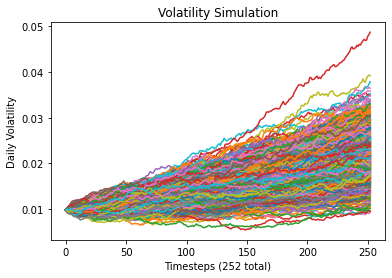

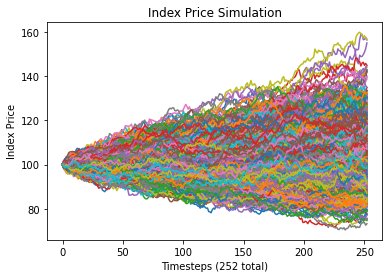

In [5]:
plot_sims(cir_sim, simulation)

In [4]:
# Calibration
step = 10
theta_grid = [-0.0006410369940794198]
kappa_grid = [-0.7647317107683925]
xi_grid    = [0.02822227791725009]
opt_comb   = None
opt_sse    = -1.
opt_out    = None
ct = 0

for theta in theta_grid:
    for kappa in kappa_grid:
        ct += 1
        for xi in xi_grid:
            params["theta"].val = theta
            params["kappa"].val = kappa
            params["xi"].val    = xi
            if feller(params):
                run_sims(cir_sim, simulation)
                out, sse = call_price(simulation.results, targets, params["r"].eval())
                if opt_sse < 0. or sse < opt_sse:
                    opt_sse = sse
                    opt_comb = (theta, kappa, xi)
                    opt_out = out
    if ct % step == 0:
        print(f"Calibration {ct // step}/{step} complete.")

In [5]:
print("SSE: = ", sse)
print("Optimal Combination = ", opt_comb)
print("Call Prices = ", opt_out)

SSE: =  22.813964518615887
Optimal Combination =  (-0.0006410369940794198, -0.7647317107683925, 0.02822227791725009)
Call Prices =  {1: {95: 5.384268535195337, 100: 2.0720236591003194, 105: 0.508938320220795}, 2: {95: 6.047098255016927, 100: 3.0828654382709892, 105: 1.3039509189468033}, 3: {100: 4.167674919975147, 105: 2.282826543207233, 110: 1.1336845033512069}, 4: {100: 5.074861494983504, 105: 3.140165683696403, 110: 1.8331145361246508}}
